## Exp 02. Insertion fragment selection - Effect of chemical environment

This file provides source codes for insertion fragment selection analysis.

First, pre-selected two molecules are queried to DeepBioisostere to yield 100 modified structures for each input molecule and property control condition.

### Basics

In [1]:
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from pathlib import Path
from typing import Dict, List
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem.FragmentMatcher import FragmentMatcher
from rdkit.Chem.QED import properties as qed_properties
from rdkit.Chem.QED import WEIGHT_MEAN, ads, adsParameters
from rdkit.Chem import BRICS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from tqdm import tqdm

from conditioning import Conditioner
from generate import Generator
from model import DeepBioisostere
from property import calc_logP, calc_Mw, calc_QED, calc_SAscore
from brics.brics import BRICSModule

pd.options.mode.chained_assignment = None


In [2]:
SMILES = str
CAPILTAIER = {"logp": "logP", "mw": "Mw", "qed": "QED", "sa": "SA"}
DELTA_PROPS = {
    "Mw": r"$\Delta Mw$",
    "logP": r"$\Delta logP$",
    "QED": r"$\Delta QED$",
    "SA": r"$\Delta SA$",
}
DE_DELTA_PROPS = {
    r"$\Delta Mw$": "Mw",
    r"$\Delta logP$": "logP",
    r"$\Delta QED$": "QED",
    r"$\Delta SA$": "SA",
}

### Define functions

In [3]:
def calculate_properties(smi: SMILES, props: List[str]) -> Dict[str, float]:
    mol = Chem.MolFromSmiles(smi)
    calculated_values = dict()
    for prop in props:
        if prop == "logp":
            calculated_values["logp"] = calc_logP(mol)
        elif prop == "mw":
            calculated_values["mw"] = calc_Mw(mol)
        elif prop == "qed":
            calculated_values["qed"] = calc_QED(mol)
        elif prop == "sa":
            calculated_values["sa"] = calc_SAscore(mol)
    return calculated_values

### Main part

##### User settings for generation

In [13]:
PROJECT_DIR = Path("/home/hwkim/DeepBioisostere")   # Change this to your project directory

batch_size = 256
num_sample_each_mol = 100
device = "cuda:0"
target_prop = "logp"
num_workers = 4
new_frag_type = "test"              # One of ["test", "val, "train", "all"]. The experiment in the paper uses "test"

##### Fragment library and DeepBioisostere generator setting

In [14]:
# experiment settings
# frag_lib_path = PROJECT_DIR.joinpath("fragment_library")      # default path. please turn on this line.
frag_lib_path = Path("/home/share/DATA/hwkim/DeepBioisostere")        # our own server :)
exp_dir = PROJECT_DIR.joinpath("exps/fig3_chemical_environment")

csv_save_dir = exp_dir.joinpath("./csv_files")
csv_save_path = csv_save_dir.joinpath(f"{target_prop}_generation_result.csv")

properties = [target_prop]

if csv_save_path.exists():
    print(
        f"Generated molecules file already exists and is to be used: {csv_save_path.absolute()}"
    )
    generator = None

else:
    joined_properties = "_".join(properties)
    model_path = Path(PROJECT_DIR).joinpath(f"model_save/DeepBioisostere_{joined_properties}.pt")
    print("Generation with DeepBioisostere would be started.")
    print(f"Model path to be loaded: {model_path.absolute()}")
    print(f"Fragment library path to be loaded: {frag_lib_path.absolute()}")

    # Initialize model, conditioner, and generator
    model = DeepBioisostere.from_trained_model(model_path, properties=properties)
    conditioner = Conditioner(
        phase="generation",
        properties=properties,
    )
    generator = Generator(
        model=model,
        processed_frag_dir=frag_lib_path,
        num_sample_each_mol=num_sample_each_mol,
        device=device,
        num_cores=num_workers,
        batch_size=batch_size,
        new_frag_type=new_frag_type,
        conditioner=conditioner,
        properties=properties,
    )

Generation with DeepBioisostere would be started.
Model path to be loaded: /home/hwkim/DeepBioisostere/model_save/DeepBioisostere_logp.pt
Fragment library path to be loaded: /home/share/DATA/hwkim/DeepBioisostere
Loading the fragment library...
Generator initialization finished.


In [15]:
# Save directory setting
current_time = datetime.now().strftime("%y%m%d_%H-%M-%S")
exp_save_dir = exp_dir.joinpath(current_time)
exp_save_dir.mkdir()
print(f"Experiment result save directory: {exp_save_dir}")


Experiment result save directory: /home/hwkim/DeepBioisostere/exps/fig3_chemical_environment/250422_11-15-59


In [16]:
# Load the test molecule pair
test_molecule_pair_data = csv_save_dir.joinpath("test_molecule_pairs.csv")
test_molecule_pair_df = pd.read_csv(test_molecule_pair_data, sep="\t")
removal_frag_smiles_pairs = set()
for row_idx, row in test_molecule_pair_df.iterrows():
    removal_frag, smi1, smi2 = row["REMOVAL-FRAG"], row["SMILES1"], row["SMILES2"]
    removal_frag_smiles_pairs.add((removal_frag, smi1, smi2))
print(
    f"Test molecule pair data path to be used: {test_molecule_pair_data.absolute()}"
)

Test molecule pair data path to be used: /home/hwkim/DeepBioisostere/exps/fig3_chemical_environment/csv_files/test_molecule_pairs.csv


##### Generation

In [17]:
if generator:
    print( f"Molecule generation result file would be saved at: {csv_save_path.absolute()}")

    # Make input list Increasing QED by +0.1 and Increasing logP by +1.0.
    if target_prop == "qed":
        prop_control_condition = {"qed": +0.1}
    elif target_prop == "logp":
        prop_control_condition = {"logp": +1.0}
    else:
        raise ValueError("Invalid target property.")

    input_list = list()
    for removal_frag, smi1, smi2 in removal_frag_smiles_pairs:
        for smiles in [smi1, smi2]:
            smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
            removal_frag_copy = deepcopy(removal_frag)
            # Initialization
            mol = Chem.MolFromSmiles(smiles)
            matcher_with_dummy = FragmentMatcher()
            matcher_with_dummy.Init(removal_frag_copy)

            matches = matcher_with_dummy.GetMatches(mol)
            if len(matches) > 1:
                continue
            match = matches[0]

            # Get matcher_without_dummy FragmentMatcher
            removal_frag_without_dummy = removal_frag_copy.replace("[*]", "")
            removal_frag_without_dummy = removal_frag_without_dummy.replace("()", "")
            matcher_without_dummy = FragmentMatcher()
            matcher_without_dummy.Init(removal_frag_without_dummy)

            matches_without_dummy = matcher_without_dummy.GetMatches(mol)
            for match_without_dummy in matches_without_dummy:
                if all(list(map(lambda x: x in match, match_without_dummy))):
                    mark_atom_idx = match_without_dummy[0]
                    break
            else:
                raise ValueError("No match_without_dummy is found.")

            # Add to input list
            removal_frag_copy = removal_frag_copy.replace("[c;H1]", "c")
            removal_frag_copy = removal_frag_copy.replace("[n;H1]", "[nH]")
            removal_frag_copy = removal_frag_copy.replace("[n;H0]", "n")
            removal_frag_copy = removal_frag_copy.replace("[s;X2]", "s")
            removal_frag_copy = removal_frag_copy.replace("[o;X2]", "o")
            removal_frag_copy = removal_frag_copy.replace("[O;H1]", "O")
            removal_frag_copy = removal_frag_copy.replace("[N;H2]", "N")
            if (smiles.strip(), removal_frag_copy, mark_atom_idx, {"qed": +0.2}) not in input_list:
                input_list.append((smiles.strip(), removal_frag_copy, mark_atom_idx, prop_control_condition))

    # 3. Generate with DeepBioisostere
    print(f"Generation with DeepBioisostere would be started. Target property: {target_prop}")
    print(f"Length of input list: {len(input_list)}")
    generation_df = generator.generate_with_leaving_frag(input_list)
    generation_df.to_csv(csv_save_path, index=False)

else:
    print(f"Generated molecule file already exists and is to be loaded:\n{csv_save_path}")
    generation_df = pd.read_csv(csv_save_path)
    print(generation_df.shape)

Molecule generation result file would be saved at: /home/hwkim/DeepBioisostere/exps/fig3_chemical_environment/csv_files/logp_generation_result.csv
Generation with DeepBioisostere would be started. Target property: logp
Length of input list: 2


##### Analyze

In [18]:
# columns: molecule-A, molecule-B, removal_frag, insertion_frag, gen-mol-smi, gen-logp, gen-qed, case

# Save Dataframe
retrieved_results = pd.DataFrame(
    columns=[
        "MOLECULE-A",
        "MOLECULE-B",
        "REMOVAL-FRAG",
        "INSERTION-FRAG",
        "GEN-MOL-SMI",
        "DELTA-LOGP",
        "DELTA-QED",
        "CASE",
    ]
)

list_mol_A, list_mol_B, list_removal_frag, list_insertion_frag, list_gen_mol_smi, list_delta_logp, list_delta_qed, list_case = [], [], [], [], [], [], [], []

topk = num_sample_each_mol
for idx, row in test_molecule_pair_df.iterrows():
    removal_frag, smi1, smi2 = row["REMOVAL-FRAG"], row["SMILES1"], row["SMILES2"]
    gen_mols_1 = generation_df[generation_df["INPUT-MOL-SMI"] == smi1]
    gen_mols_2 = generation_df[generation_df["INPUT-MOL-SMI"] == smi2]
    if gen_mols_1.shape[0] > 3*topk or gen_mols_2.shape[0] > 3*topk:
        continue

    # properties of original molecules
    mol1, mol2 = Chem.MolFromSmiles(smi1), Chem.MolFromSmiles(smi2)
    logp1, logp2 = calc_logP(mol1), calc_logP(mol2)
    qed1, qed2 = calc_QED(mol1), calc_QED(mol2)

    # NOTE: molecule-A = smi1, molecule-B = smi2
    # 1. A -> B
    topk_insertion_frag_in_A = gen_mols_1["INSERTING-FRAG-SMI"].values[:topk]
    removal_frag_without_dummy = removal_frag.replace("[*]", "").replace("()", "")

    # Find remaining frags
    fm = FragmentMatcher()
    fm.Init(removal_frag_without_dummy)
    matches_in_B = fm.GetMatches(mol2)
    if len(matches_in_B) > 1:
        continue

    match_in_B = matches_in_B[0]
    brics_bonds_in_B = BRICS.FindBRICSBonds(mol2)
    target_brics_bond = list(filter(lambda x: x[0][0] in match_in_B or x[0][1] in match_in_B, brics_bonds_in_B))
    broken_mol = BRICS.BreakBRICSBonds(mol2, target_brics_bond)
    # remaining_frag = list(filter(lambda x: x != target_frag_smiles_list[0], Chem.MolToSmiles(broken_mol).split(".")))
    remaining_frag = max(Chem.MolToSmiles(broken_mol).split("."), key=lambda x: len(x))

    # Merge remaining frag and insertiong frags from molecule A
    for insertion_frag_in_A in topk_insertion_frag_in_A:
        remaining_frag_mol = Chem.MolFromSmiles(remaining_frag)
        remaining_frag_dummy_atom_idx = [atom.GetIdx() for atom in remaining_frag_mol.GetAtoms() if atom.GetSymbol() == "*"][0]
        neighbor_atom_idx = remaining_frag_mol.GetAtomWithIdx(remaining_frag_dummy_atom_idx).GetNeighbors()[0].GetIdx()

        insertion_frag_mol = Chem.MolFromSmiles(insertion_frag_in_A)
        composed_mol = BRICSModule.compose_two_mols(remaining_frag_mol, insertion_frag_mol, neighbor_atom_idx)

        list_mol_A.append(smi1)
        list_mol_B.append(smi2)
        list_removal_frag.append(removal_frag)
        list_insertion_frag.append(insertion_frag_in_A)
        list_gen_mol_smi.append(Chem.MolToSmiles(composed_mol))
        list_delta_logp.append(calc_logP(composed_mol) - logp2)
        list_delta_qed.append(calc_QED(composed_mol) - qed2)
        list_case.append(r"A $\rightarrow$ B")

    # 2. A -> A
    list_mol_A.extend([smi1] * topk)
    list_mol_B.extend([smi2] * topk)
    list_removal_frag.extend([removal_frag] * topk)
    list_insertion_frag.extend(gen_mols_1["INSERTING-FRAG-SMI"].values[:topk])
    list_gen_mol_smi.extend(gen_mols_1["GEN-MOL-SMI"].values[:topk])
    list_delta_logp.extend(gen_mols_1["LOGP"].values[:topk] - logp1)
    list_delta_qed.extend(gen_mols_1["QED"].values[:topk] - qed1)
    list_case.extend([r"A $\rightarrow$ A"] * topk)

    # 3. B -> B
    list_mol_A.extend([smi1] * topk)
    list_mol_B.extend([smi2] * topk)
    list_removal_frag.extend([removal_frag] * topk)
    list_insertion_frag.extend(gen_mols_2["INSERTING-FRAG-SMI"].values[:topk])
    list_gen_mol_smi.extend(gen_mols_2["GEN-MOL-SMI"].values[:topk])
    list_delta_logp.extend(gen_mols_2["LOGP"].values[:topk] - logp2)
    list_delta_qed.extend(gen_mols_2["QED"].values[:topk] - qed2)
    list_case.extend([r"B $\rightarrow$ B"] * topk)

# Save to the dataframe
retrieved_results["MOLECULE-A"] = list_mol_A
retrieved_results["MOLECULE-B"] = list_mol_B
retrieved_results["REMOVAL-FRAG"] = list_removal_frag
retrieved_results["INSERTION-FRAG"] = list_insertion_frag
retrieved_results["GEN-MOL-SMI"] = list_gen_mol_smi
retrieved_results["DELTA-LOGP"] = list_delta_logp
retrieved_results["DELTA-QED"]  = list_delta_qed
retrieved_results["CASE"] = list_case

# Save to the csv file
retrieved_results.to_csv(exp_save_dir / f"{target_prop}_data_for_figure.csv", index=False)
retrieved_results.to_csv(csv_save_dir / f"{target_prop}_data_for_figure.csv", index=False)
        

##### Plot figures

0, molA:Cc1nc2ccc(Cl)cc2c(-n2ccc3c(O)cc(-c4cn[nH]c4)cc32)c1C, molB:NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CS)NC(=O)c1cn[nH]c1

0, molA:Cc1nc2ccc(Cl)cc2c(-n2ccc3c(O)cc(-c4cn[nH]c4)cc32)c1C, molB:NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CS)NC(=O)c1cn[nH]c1


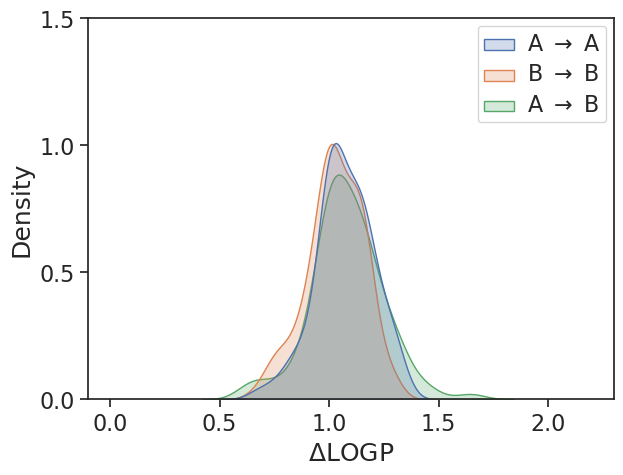

In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="ticks")
result_df = retrieved_results

unique_inputs_set = set()
mol_A_list = result_df["MOLECULE-A"].to_list()
mol_B_list = result_df["MOLECULE-B"].to_list()
removal_frag_list = result_df["REMOVAL-FRAG"].to_list()

for mol_A, mol_B, removal_frag in zip(mol_A_list, mol_B_list, removal_frag_list):
    unique_inputs_set.add((mol_A, mol_B, removal_frag))

for idx, (mol_A, mol_B, removal_frag) in enumerate(unique_inputs_set):
    print(f"{idx}, molA:{mol_A}, molB:{mol_B}")
print()

for idx, (mol_A, mol_B, removal_frag) in enumerate(unique_inputs_set):
    print(f"{idx}, molA:{mol_A}, molB:{mol_B}")
    each_df = result_df[
        (result_df["MOLECULE-A"] == mol_A)
        & (result_df["MOLECULE-B"] == mol_B)
        & (result_df["REMOVAL-FRAG"] == removal_frag)
        # & (result_df["CASE"] != "B $\\rightarrow$ B")
    ]
    removal_frag = each_df["REMOVAL-FRAG"].to_list()[0]

    # 1. kdeplot without histogram
    g = sns.kdeplot(
        data=each_df,
        x = f"DELTA-{target_prop.upper()}",
        hue = "CASE",
        hue_order=[r"A $\rightarrow$ A", r"B $\rightarrow$ B", r"A $\rightarrow$ B"],
        fill = True,
    )
    plt.fill_between(x=each_df[f"DELTA-{target_prop.upper()}"], y1=0, alpha=0.3)

    # Setting font sizes
    g.axes.set_xlabel(f"$\Delta${target_prop.upper()}", fontsize=18)
    g.axes.set_ylabel("Density", fontsize=18)

    legend = g.axes.get_legend()
    legend.set_title("")
    for text in legend.texts:
        text.set_fontsize(16)
    legend.loc = "upper left"

    # Set x and y ticks
    x_ticks = list(g.axes.get_xticks())
    y_ticks = list(g.axes.get_yticks())

    x_min, x_max = x_ticks[0], x_ticks[-1]
    # x_min = round(x_min * 20) / 20
    # x_max = round(x_max * 20) / 20
    if target_prop == 'qed':
        x_min = -0.4
        x_max = 0.4
        if x_max-x_min > 1.0:
            tick_size = 0.2
        else:
            tick_size = 0.1
    elif target_prop == 'logp':
        x_min = 0.0
        x_max = 2.0
        plt.xlim(-0.1, 2.3)
        if x_max-x_min > 1.0:
            tick_size = 0.5
        else:
            tick_size = 0.1
    x_ticks = list(np.arange(x_min, x_max + 0.05, tick_size))
    y_min, y_max = y_ticks[0], y_ticks[-1]
    y_ticks = list(np.arange(y_min, y_max + 0.3, 0.5))

    g.axes.set_xticks(x_ticks)
    g.axes.set_yticks(y_ticks)
    g.axes.set_xticklabels(g.axes.get_xticklabels(), fontsize=16)
    g.axes.set_yticklabels(g.axes.get_yticklabels(), fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)

    plt.savefig(exp_save_dir / f"kde_{target_prop}_{idx}.pdf", format="pdf", facecolor="white")
    plt.show()
    plt.close("all")

